**Domain Description :**

**States :**

For the purpose of this experiment a 4x4 GridWorld has been chosen.

Start state : state '00' is the start state

Terminal state : state '15' is the end state

**Action :**

Up, down, left and right (all of which are equally likely at every state)

** Reward Structure :**

* If the robot hits the wall of the grid : 0
* If the robot reaches the exit : +1
* Everywhere else : -1

**Environment :**

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [20]:
#Learning Rate for calculation of expected value function
#ALPHA = 0.2

#Discount Factor
GAMMA = 1

#Number of Episodes
NUM_EPISODES = 100

EPSILON = 0.1

#Number of episodes
#n_episodes = 2000

#Number of look-ahead steps. This is 1 for TD(0)
n_runs = 100

#Different learning parameters
alphas = [0.01, 0.05, 0.1, 0.5, 0.9]
#alphas = [0.5]

#Maximum Episode Length
MAX_EPISODE_LENGTH = 5000

In [21]:
#Define States
states = ['00', '01', '02','03',
          '04', '05','06', '07',
          '08', '09', '10', '11',
          '12', '13', '14','15']

In [4]:
START_STATE = '00'
EXIT_STATE = '15'

In [5]:
intermediate_states = [s for s in states if s not in EXIT_STATE]

In [6]:
#Define Actions
actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

UP = 'UP'
DOWN = 'DOWN'
LEFT = 'LEFT'
RIGHT = 'RIGHT'

In [7]:
state_transitions = {
                '00' : {UP : '00', DOWN : '04', LEFT : '00', RIGHT : '01'},
                '01' : {UP : '01', DOWN : '05', LEFT : '00', RIGHT : '02'},
                '02' : {UP : '02', DOWN : '06', LEFT : '01', RIGHT : '03'},
                '03' : {UP : '03', DOWN : '07', LEFT : '02', RIGHT : '03'},   
                '04' : {UP : '00', DOWN : '08', LEFT : '04', RIGHT : '05'}, 
                '05' : {UP : '01', DOWN : '09', LEFT : '04', RIGHT : '06'},
                '06' : {UP : '02', DOWN : '10', LEFT : '05', RIGHT : '07'},   
                '07' : {UP : '03', DOWN : '11', LEFT : '06', RIGHT : '07'},    
                '08' : {UP : '04', DOWN : '12', LEFT : '08', RIGHT : '09'},
                '09' : {UP : '05', DOWN : '13', LEFT : '08', RIGHT : '10'},
                '10' : {UP : '06', DOWN : '14', LEFT : '09', RIGHT : '11'},
                '11' : {UP : '07', DOWN : '15', LEFT : '10', RIGHT : '11'},
                '12' : {UP : '08', DOWN : '12', LEFT : '12', RIGHT : '13'},
                '13' : {UP : '09', DOWN : '13', LEFT : '12', RIGHT : '14'},
                '14' : {UP : '10', DOWN : '14', LEFT : '13', RIGHT : '15'},
                '15' : {UP : '15', DOWN : '15', LEFT : '15', RIGHT : '15'}
              }

In [17]:
#Q = {}

In [8]:
def initializeQ():
    Q = {
    '00' : {UP : 0, DOWN : 0, LEFT : 0, RIGHT : 0},
    '01' : {UP : 0, DOWN : 0, LEFT : 0, RIGHT : 0},
    '02' : {UP : 0, DOWN : 0, LEFT : 0, RIGHT : 0},
    '03' : {UP : 0, DOWN : 0, LEFT : 0, RIGHT : 0},   
    '04' : {UP : 0, DOWN : 0, LEFT : 0, RIGHT : 0}, 
    '05' : {UP : 0, DOWN : 0, LEFT : 0, RIGHT : 0},
    '06' : {UP : 0, DOWN : 0, LEFT : 0, RIGHT : 0},   
    '07' : {UP : 0, DOWN : 0, LEFT : 0, RIGHT : 0},    
    '08' : {UP : 0, DOWN : 0, LEFT : 0, RIGHT : 0},
    '09' : {UP : 0, DOWN : 0, LEFT : 0, RIGHT : 0},
    '10' : {UP : 0, DOWN : 0, LEFT : 0, RIGHT : 0},
    '11' : {UP : 0, DOWN : 0, LEFT : 0, RIGHT : 0},
    '12' : {UP : 0, DOWN : 0, LEFT : 0, RIGHT : 0},
    '13' : {UP : 0, DOWN : 0, LEFT : 0, RIGHT : 0},
    '14' : {UP : 0, DOWN : 0, LEFT : 0, RIGHT : 0},
    '15' : {UP : 0, DOWN : 0, LEFT : 0, RIGHT : 0}
    }
    return Q

In [9]:
def chooseGreedyAction(state, Q):
    bestAction = 'UP'
    maxQ = Q[state][bestAction]
    for action in actions:
        if Q[state][action] > maxQ:
            maxQ = Q[state][action]
            bestAction = action
    return bestAction

In [10]:
def generateActionBehaviorPolicy(state, epsilon, Q):
    explore_prob = random.uniform(0,1)
    
    if explore_prob >= epsilon:
        #Exploit
        action = chooseGreedyAction(state, Q)
        return action
    else:
        #Explore
        random_prob = random.uniform(0,1)
        #print random_prob
        if random_prob >= 0.75:
            return 'RIGHT'
        elif random_prob >= 0.5:
            return 'DOWN'
        elif random_prob >= 0.25:
            return 'LEFT'
        else:
            return 'UP'

In [11]:
def immediateReward(currentState, action):
    nextState = state_transitions[currentState][action]
    if currentState == nextState:
        reward = 0
    elif nextState in EXIT_STATE:
        reward = 1
    else:
        reward = -1
    return reward

In [12]:
def generateEpisodeBehaviorPolicy(epsilon, Q):
    state = START_STATE
    episodes = []
    all_states = []
    all_actions = []
    all_rewards = []
    
    while (state != EXIT_STATE) and len(all_states) <= MAX_EPISODE_LENGTH:
        action = generateActionBehaviorPolicy(state, epsilon, Q)
        reward = immediateReward(state, action)
        all_states.append(state)
        all_actions.append(action)
        all_rewards.append(reward)
        state = state_transitions[state][action]
    episodes.append(zip(all_states, all_actions, all_rewards))
    return episodes

### SARSA : On-Policy TD Control

In [16]:
def sarsa(EPSILON, ALPHA):
    episode_lengths_all_runs = np.zeros((NUM_EPISODES, n_runs))
    episode_rewards_all_runs = np.zeros((NUM_EPISODES, n_runs))
    
    for k in range(n_runs):
    
        episode_lengths = np.zeros(NUM_EPISODES)
        episode_rewards = np.zeros(NUM_EPISODES)

        episode_number = []

        Q = initializeQ()

        for episode_i in range(NUM_EPISODES):
            episode = generateEpisodeBehaviorPolicy(EPSILON, Q)

            for step in range(len(episode[0])):
                state, action, reward = episode[0][step]
                if (step == len(episode[0]) - 1):
                    exp_return = reward
                else:
                    nextState, nextAction, nextReward = episode[0][step + 1]
                    exp_return = reward + GAMMA * Q[nextState][nextAction]
                Q[state][action] += ALPHA * (exp_return - Q[state][action])

                episode_number.append(episode_i)

                episode_rewards[episode_i] += reward
                
            episode_rewards_all_runs[:,k] = episode_rewards
            
            episode_lengths_all_runs[episode_i, k] = len(episode[0])
            #episode_lengths[episode_i] = len(episode[0])
            
            avg_episode_length = np.mean(episode_lengths_all_runs, axis=1)
    return episode_number, avg_episode_length, episode_rewards_all_runs

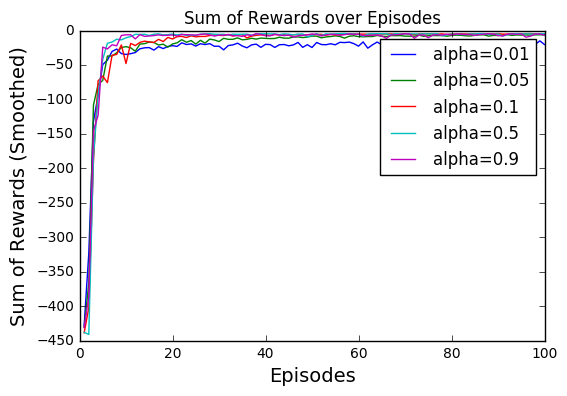

In [22]:
avg_reward_all_runs = np.zeros((NUM_EPISODES, len(alphas)))
episode_number_all_runs = []
avg_episode_lengths_all_runs = np.zeros((NUM_EPISODES, len(alphas)))

for i in range(len(alphas)):
    episode_number, avg_episode_length, episode_rewards_all_runs = sarsa(EPSILON, alphas[i])
    
    avg_reward = np.mean(episode_rewards_all_runs, axis=1)
    avg_reward_all_runs[:,i] = avg_reward
    
    avg_episode_lengths_all_runs[:,i] = avg_episode_length
    
    episode_number_all_runs.append(episode_number)
    plt.plot(np.arange(NUM_EPISODES) + 1, avg_reward_all_runs[:,i], label='alpha=' + str(alphas[i]))
    
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Sum of Rewards (Smoothed)', fontsize=14)
plt.legend(loc='upper right')
plt.title('Sum of Rewards over Episodes')
plt.show()

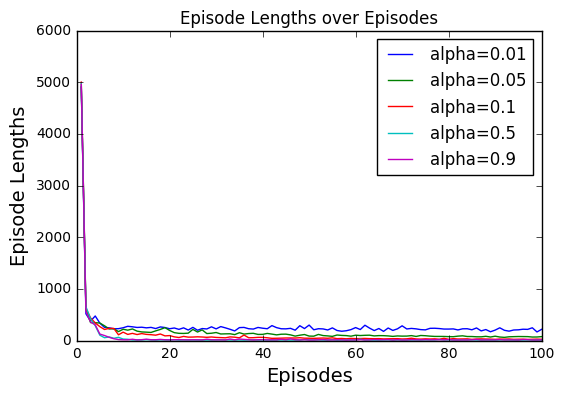

In [23]:
for i in range(len(alphas)):
    plt.plot(np.arange(NUM_EPISODES) + 1, avg_episode_lengths_all_runs[:,i], label='alpha=' + str(alphas[i]))
    
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Episode Lengths', fontsize=14)
plt.legend(loc='upper right')
plt.title('Episode Lengths over Episodes')
plt.show()

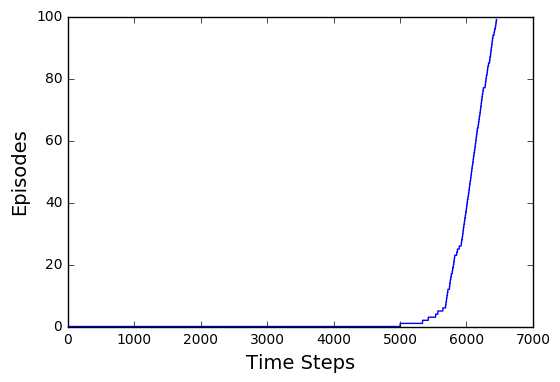

In [24]:
plt.plot(np.arange(len(episode_number)) + 1, np.asarray(episode_number))

plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Episodes', fontsize=14)
plt.show()

### Q-Learning : Off-Policy TD Control

In [27]:
def qLearning(EPSILON, ALPHA):
    episode_lengths_all_runs = np.zeros((NUM_EPISODES, n_runs))
    episode_rewards_all_runs = np.zeros((NUM_EPISODES, n_runs))
    
    for k in range(n_runs):
    
        episode_lengths = np.zeros(NUM_EPISODES)
        episode_rewards = np.zeros(NUM_EPISODES)

        episode_number = []

        Q = initializeQ()

        for episode_i in range(NUM_EPISODES):
            episode = generateEpisodeBehaviorPolicy(EPSILON, Q)

            for step in range(len(episode[0])):
                state, action, reward = episode[0][step]
                if (step == len(episode[0]) - 1):
                    exp_return = reward
                else:
                    nextState, nextAction, nextReward = episode[0][step + 1]
                    nextAction = chooseGreedyAction(state, Q)
                    exp_return = reward + GAMMA * Q[nextState][nextAction]
                Q[state][action] += ALPHA * (exp_return - Q[state][action])

                episode_number.append(episode_i)

                episode_rewards[episode_i] += reward
                
            episode_rewards_all_runs[:,k] = episode_rewards
            
            episode_lengths_all_runs[episode_i, k] = len(episode[0])
            #episode_lengths[episode_i] = len(episode[0])
            
            avg_episode_length = np.mean(episode_lengths_all_runs, axis=1)
    return episode_number, avg_episode_length, episode_rewards_all_runs

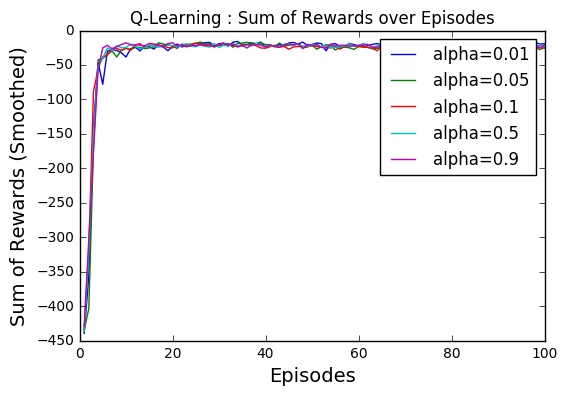

In [29]:
avg_reward_all_runs_Q = np.zeros((NUM_EPISODES, len(alphas)))
episode_number_all_runs_Q = []
avg_episode_lengths_all_runs_Q = np.zeros((NUM_EPISODES, len(alphas)))

for i in range(len(alphas)):
    episode_number_Q, avg_episode_length_Q, episode_rewards_all_runs_Q = qLearning(EPSILON, alphas[i])
    
    avg_reward_Q = np.mean(episode_rewards_all_runs_Q, axis=1)
    avg_reward_all_runs_Q[:,i] = avg_reward_Q
    
    avg_episode_lengths_all_runs_Q[:,i] = avg_episode_length_Q
    
    episode_number_all_runs_Q.append(episode_number_Q)
    plt.plot(np.arange(NUM_EPISODES) + 1, avg_reward_all_runs_Q[:,i], label='alpha=' + str(alphas[i]))
    
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Sum of Rewards (Smoothed)', fontsize=14)
plt.legend(loc='upper right')
plt.title('Q-Learning : Sum of Rewards over Episodes')
plt.show()

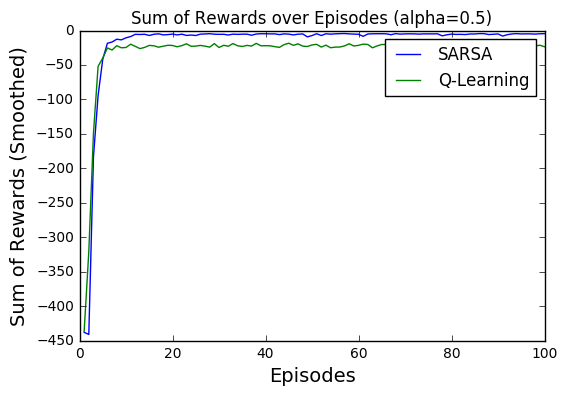

In [33]:
i = 3
plt.plot(np.arange(NUM_EPISODES) + 1, avg_reward_all_runs[:,i], label='SARSA')
plt.plot(np.arange(NUM_EPISODES) + 1, avg_reward_all_runs_Q[:,i], label='Q-Learning')

plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Sum of Rewards (Smoothed)', fontsize=14)
plt.legend(loc='upper right')
plt.title('Sum of Rewards over Episodes '+'(alpha='+str(alphas[i])+')')
plt.show()

### Expected Sarsa